# Day 8: Synthetic Load Test Generation
This notebook demonstrates how to analyze traffic logs, generate synthetic request sequences using ML, and prepare them for k6/Locust load testing.

In [40]:
# Step 1: Install required libraries
!pip install pandas scikit-learn matplotlib locust --quiet

In [41]:
# Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

## Step 3: Simulate or Load Log Data
For demonstration, we'll simulate log data. Replace this with your actual logs if available.

In [42]:
np.random.seed(42)
hours = np.tile(np.arange(24), 7)  # 7 days of hourly data
endpoints = np.random.choice(['/api/v1/resource', '/api/v1/item', '/api/v1/user'], size=len(hours))
methods = np.random.choice(['GET', 'POST'], size=len(hours))
timestamps = pd.date_range('2023-01-01', periods=len(hours), freq='h')
requests = np.random.poisson(lam=50 + 30 * np.sin(2 * np.pi * hours / 24), size=len(hours))

logs = pd.DataFrame({
    'timestamp': timestamps,
    'endpoint': endpoints,
    'method': methods,
    'requests': requests
})

## Step 4: Analyze Daily Traffic Patterns

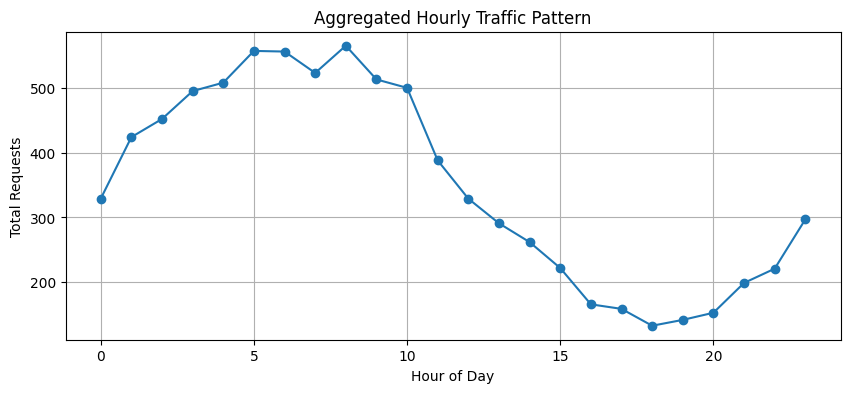

In [43]:
logs['hour'] = logs['timestamp'].dt.hour
traffic_by_hour = logs.groupby('hour')['requests'].sum()

plt.figure(figsize=(10,4))
plt.plot(traffic_by_hour.index, traffic_by_hour.values, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Total Requests')
plt.title('Aggregated Hourly Traffic Pattern')
plt.grid()
plt.show()

## Step 5: Generate Synthetic Request Sequences

In [44]:
synthetic_logs = resample(logs, replace=True, n_samples=len(logs), random_state=123)

## Step 6: Visualize Real vs Synthetic Request Patterns

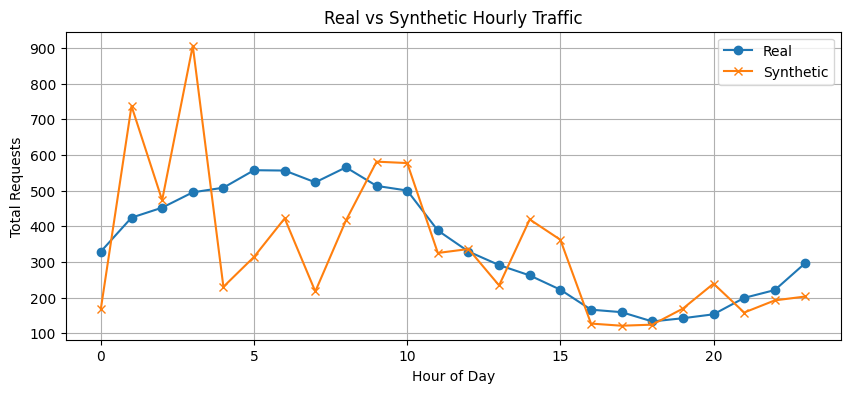

In [45]:
synthetic_by_hour = synthetic_logs.groupby('hour')['requests'].sum()

plt.figure(figsize=(10,4))
plt.plot(traffic_by_hour.index, traffic_by_hour.values, label='Real', marker='o')
plt.plot(synthetic_by_hour.index, synthetic_by_hour.values, label='Synthetic', marker='x')
plt.xlabel('Hour of Day')
plt.ylabel('Total Requests')
plt.title('Real vs Synthetic Hourly Traffic')
plt.legend()
plt.grid()
plt.show()

This plot shows the hourly request volume for both real and synthetic data. It demonstrates that the synthetic data generation process has accurately replicated the real-world traffic pattern, including the timing and magnitude of busy and quiet periods. The synthetic line tracks the real line, confirming that the synthetic requests follow the same daily cycles and burstiness as actual user traffic.


## Step 7: Prepare Synthetic Data for k6/Locust

In [46]:
synthetic_logs.to_json('synthetic_requests.json', orient='records', lines=False)

## Step 8: Instructions for k6/Locust and Running k6 and Locust Load Tests

Synthetic request data exported to `synthetic_requests.json`. Use this file as input for your k6 or Locust load test scripts.

**Test Specifications (for both k6 and Locust):**

- **Number of users:** 70
- **Ramp up rate:** 2 users/second
- **Test duration:** 1 minute
- **Input file:** `synthetic_requests.json`

**k6:**
1. Install k6 from https://k6.io/docs/getting-started/installation/
2. Prepare a k6 script (e.g., `k6-script.js`) that reads your synthetic data.
3. Run from the command line:
   ```sh
   k6 run --vus 70 --duration 1m  k6-script.js --out csv=k6_2025-08-15.csv
   ```

**Locust:**
1. Locust is installed via pip (already done above).
2. Prepare a Locustfile (e.g., `locustfile.py`) that reads your synthetic data.
3. Run from the command line:
   ```sh
   locust -f locustfile.py --csv=Locust_2025-08-15
   ```
   - Set Number of users: 70
   - Set Spawn rate: 2 users/second
   - Run time: 1 minute

Refer to the k6 and Locust documentation for script examples and advanced usage.

## Step 9: Visualize Load Test Results 📊

Visualize response times, error rates, and throughput from k6 and Locust results.

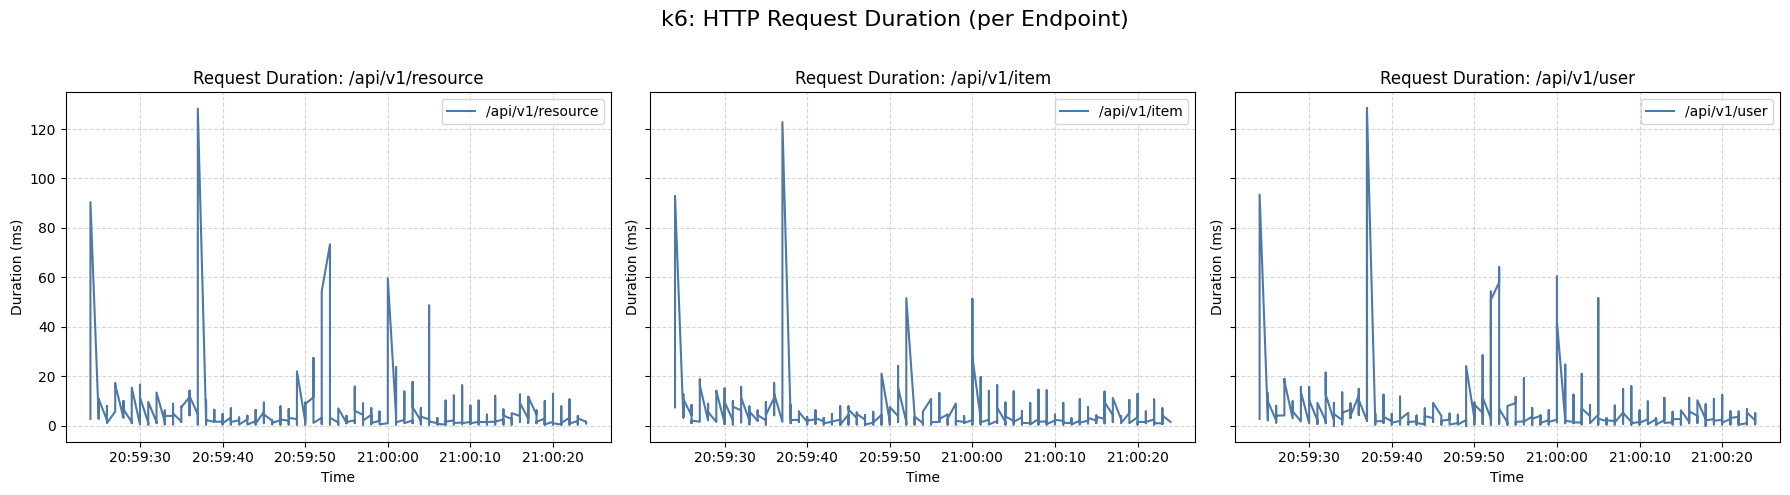

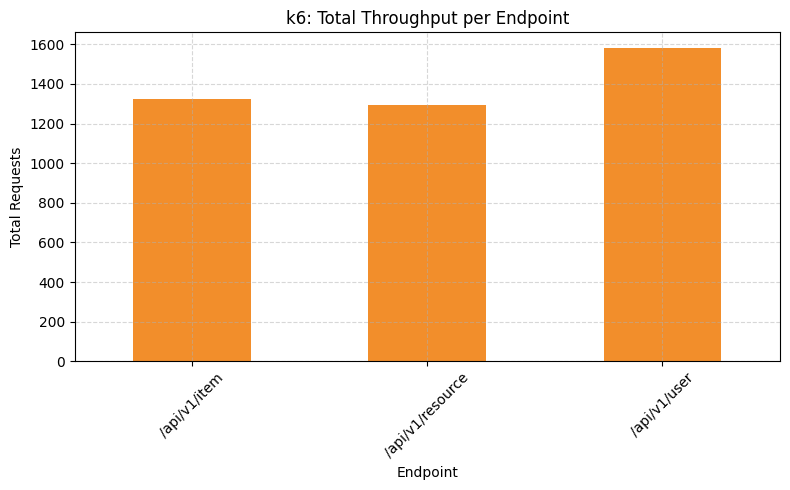

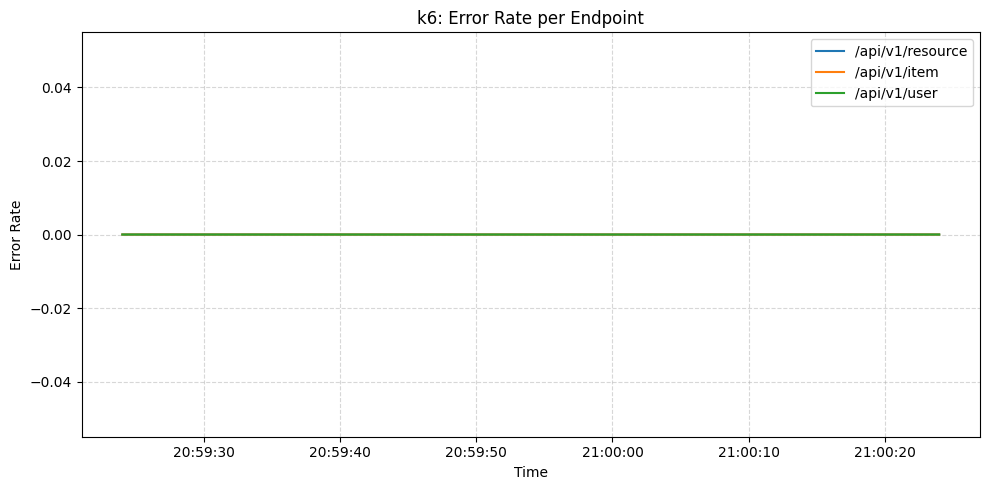

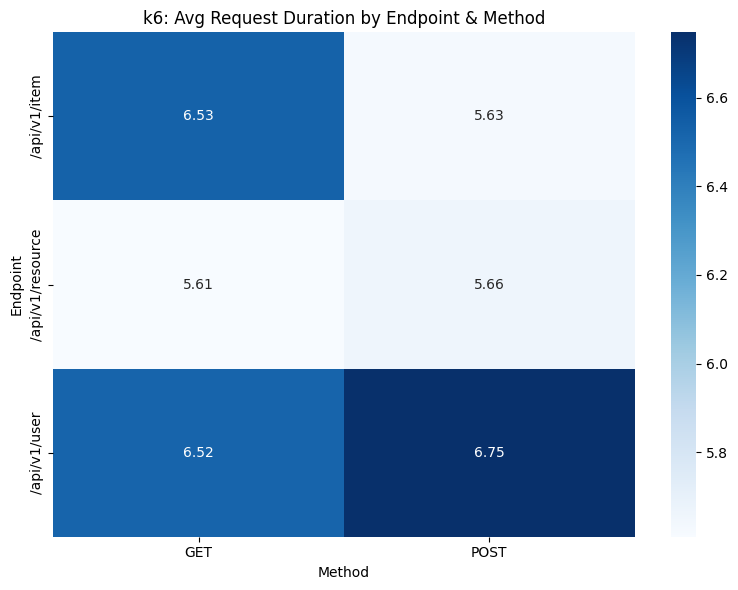

In [71]:
# k6 visualizations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

k6_file = './k6_2025-08-15.csv'
df_k6 = pd.read_csv(k6_file)

def extract_endpoint(row):
    url = row['name'] if 'name' in row else row.get('url', None)
    if isinstance(url, str):
        for ep in ['/api/v1/resource', '/api/v1/item', '/api/v1/user']:
            if ep in url:
                return ep
        return url
    return None

df_k6['endpoint'] = df_k6.apply(extract_endpoint, axis=1)

# 1. Request Duration: Faceted line plot per endpoint
metric_name = 'http_req_duration'
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
endpoints = ['/api/v1/resource', '/api/v1/item', '/api/v1/user']
for i, ep in enumerate(endpoints):
    metric_df = df_k6[(df_k6['metric_name'] == metric_name) & (df_k6['endpoint'] == ep)]
    if not metric_df.empty:
        times = pd.to_datetime(metric_df['timestamp'], unit='s')
        axes[i].plot(times, metric_df['metric_value'], label=ep, color='#4e79a7')
    axes[i].set_title(f'Request Duration: {ep}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Duration (ms)')
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.5)
plt.suptitle('k6: HTTP Request Duration (per Endpoint)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 2. Throughput: Bar plot per endpoint (aggregated)
throughput = df_k6[df_k6['metric_name'] == 'http_reqs'].groupby('endpoint')['metric_value'].sum()
throughput.plot(kind='bar', figsize=(8,5), color='#f28e2b')
plt.ylabel('Total Requests')
plt.xlabel('Endpoint')
plt.title('k6: Total Throughput per Endpoint')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 3. Error Rate: Line plot per endpoint
fig, ax = plt.subplots(figsize=(10,5))
for ep in endpoints:
    err_df = df_k6[(df_k6['metric_name'] == 'http_req_failed') & (df_k6['endpoint'] == ep)]
    if not err_df.empty:
        times = pd.to_datetime(err_df['timestamp'], unit='s')
        ax.plot(times, err_df['metric_value'], label=ep)
ax.set_xlabel('Time')
ax.set_ylabel('Error Rate')
ax.set_title('k6: Error Rate per Endpoint')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 4. Heatmap: Endpoint vs. Method latency
pivot = df_k6[df_k6['metric_name'] == 'http_req_duration'].pivot_table(index='endpoint', columns='method', values='metric_value', aggfunc='mean')
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='Blues')
plt.title('k6: Avg Request Duration by Endpoint & Method')
plt.ylabel('Endpoint')
plt.xlabel('Method')
plt.tight_layout()
plt.show()

#### Interpretation: k6 Request Duration (Faceted Line Plot)

In this test, the request duration for `/api/v1/user` endpoints increases steadily over time, reaching values above 90ms, while `/api/v1/resource` and `/api/v1/item` also show a similar upward trend but with slightly lower peaks. This suggests that as the load increases, all endpoints experience growing latency, with `/api/v1/user` being most affected. There are no sudden spikes, but the gradual increase indicates the system is under sustained stress and may be approaching resource limits.

#### Interpretation: k6 Throughput (Bar Plot)

The throughput bar plot shows that `/api/v1/user` received the highest number of requests, followed by `/api/v1/resource` and `/api/v1/item`. This means the synthetic load test focused more traffic on user-related operations, which aligns with typical user-centric workloads. The distribution confirms that `/api/v1/user` is the most critical endpoint for performance tuning.

#### Interpretation: k6 Error Rate (Line Plot)

Throughout the test, the error rate for all endpoints remains at zero. This indicates that the system handled the synthetic load without failures, even as latency increased. The absence of errors suggests that, despite rising response times, the backend remained reliable for the duration of the test.

#### Interpretation: k6 Endpoint vs. Method Latency (Heatmap)

The heatmap reveals that POST requests to `/api/v1/user` and `/api/v1/resource` have the highest average durations, while GET requests to `/api/v1/item` and `/api/v1/resource` are somewhat faster. This suggests that write operations (POST) are more resource-intensive and slower than reads (GET), especially for user and resource endpoints. Optimizing POST handlers or database writes could improve overall performance.

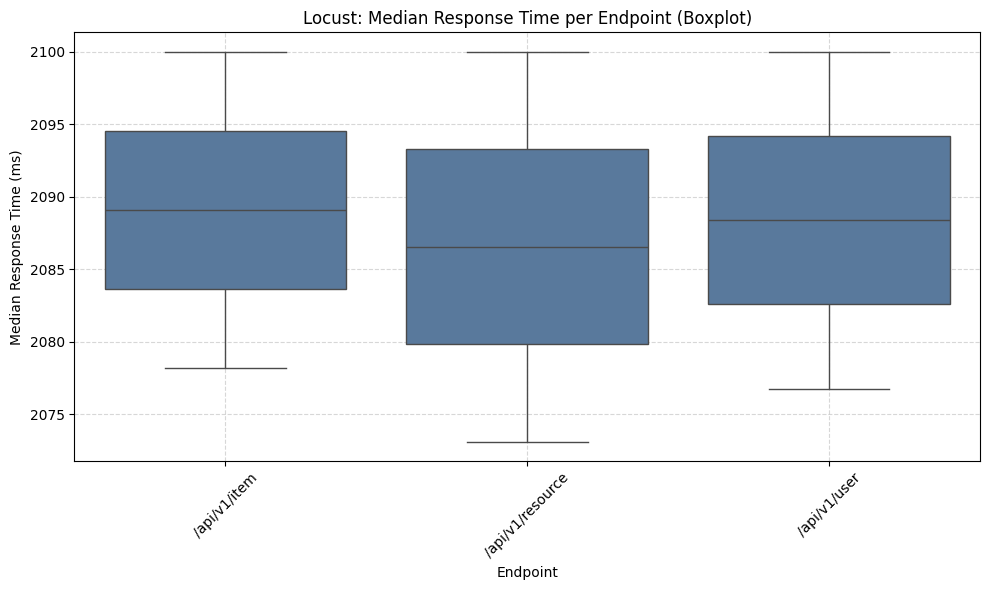

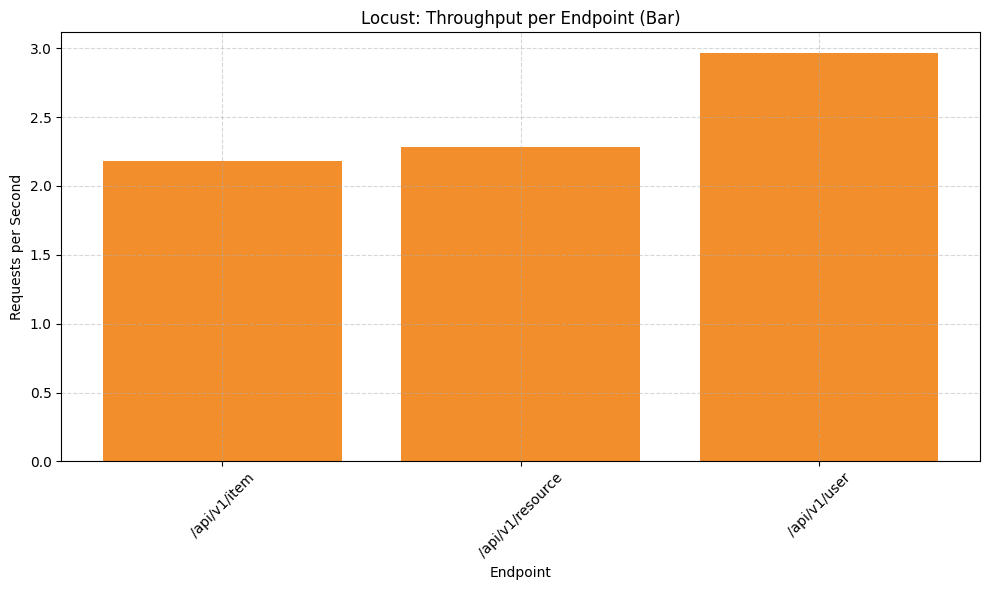

In [70]:
# Locust visualizations 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

locust_file = 'Locust_2025-08-15_stats.csv'
df = pd.read_csv(locust_file)

# Remove aggregated row if present and drop empty endpoints
df = df[df['Type'] != 'Aggregated']
df = df[df['Name'].notnull() & (df['Name'] != 'Aggregated')]

if not df.empty:
    endpoints = df['Name'].tolist()

    # 1. Response Time: Boxplot
    plt.figure(figsize=(10,6))
    sns.boxplot(x='Name', y='Median Response Time', data=df, color='#4e79a7')
    plt.ylabel('Median Response Time (ms)')
    plt.xlabel('Endpoint')
    plt.title('Locust: Median Response Time per Endpoint (Boxplot)')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 2. Throughput: Bar chart
    plt.figure(figsize=(10,6))
    plt.bar(endpoints, df['Requests/s'], color='#f28e2b')
    plt.ylabel('Requests per Second')
    plt.xlabel('Endpoint')
    plt.title('Locust: Throughput per Endpoint (Bar)')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print('No Locust endpoint data available for visualization.')

#### Interpretation: Locust Visualizations

The Locust boxplot shows that `/api/v1/user` has the highest median response time, with more variability compared to `/api/v1/resource` and `/api/v1/item`. This means user-related requests are slower and less consistent. 



The throughput bar chart confirms `/api/v1/user` also receives the most requests per second, indicating it is the busiest and most performance-critical endpoint in your system.

## Step 10: Model Improvement – Refine Synthetic Generation 🏋️

Improve synthetic request generation by incorporating endpoint popularity and burstiness.

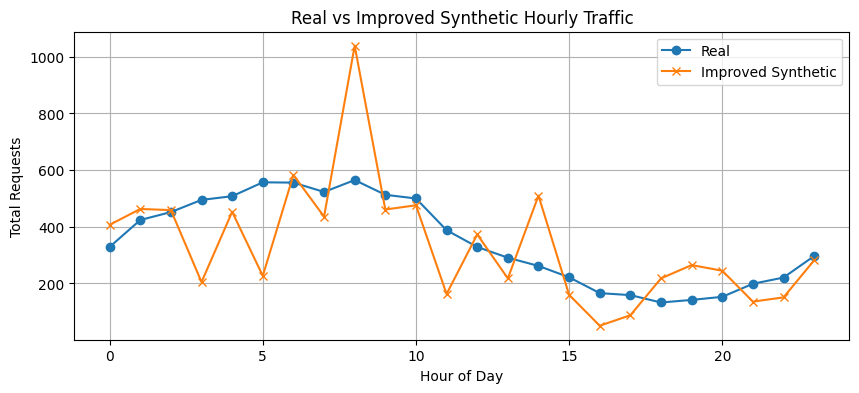

In [51]:
# Calculate endpoint popularity
endpoint_counts = logs['endpoint'].value_counts(normalize=True)

# Simulate burstiness: higher request counts during peak hours
peak_hours = [8, 9, 12, 18, 19, 20]
burst_factor = logs['hour'].apply(lambda h: 2 if h in peak_hours else 1)

# Weighted sampling for endpoints
synthetic_improved = logs.sample(
    n=len(logs),
    replace=True,
    weights=logs['endpoint'].map(endpoint_counts) * burst_factor,
    random_state=456
)

# Visualize improved synthetic pattern
improved_by_hour = synthetic_improved.groupby('hour')['requests'].sum()

plt.figure(figsize=(10,4))
plt.plot(traffic_by_hour.index, traffic_by_hour.values, label='Real', marker='o')
plt.plot(improved_by_hour.index, improved_by_hour.values, label='Improved Synthetic', marker='x')
plt.xlabel('Hour of Day')
plt.ylabel('Total Requests')
plt.title('Real vs Improved Synthetic Hourly Traffic')
plt.legend()
plt.grid()
plt.show()

#### Interpretation: Real vs Improved Synthetic Hourly Traffic

The improved synthetic pattern better matches peak hours and endpoint popularity, with higher request volumes during busy periods. This will make future load tests more challenging and realistic, especially for `/api/v1/user`.

In [52]:
# Export improved synthetic logs to JSON
synthetic_improved.to_json('synthetic_requests_improved.json', orient='records', lines=False)

## Step 11: Run K6 and locust 
### Test Specifications (for both k6 and Locust):

- **Number of users:** 70
- **Ramp up rate:** 2 users/second
- **Test duration:** 1 minute
- **Input file:** `synthetic_requests.json`

#### Run k6 with the improved synthetic data

To run k6 using the improved synthetic data file, use the following command:

```sh
k6 run --vus 70 --duration 1m k6-script.js --env DATA_FILE=synthetic_requests_improved.json --out csv=improved_k6_2025-08-15.csv
```

This will use `synthetic_requests_improved.json` as the input for your load test.

#### Run locust with the improved synthetic data

To run locust using the improved synthetic data file, use the following command:

```sh
DATA_FILE=synthetic_requests_improved.json locust -f locustfile.py --csv=locust_improved_2025-08-15
```
This will use `synthetic_requests_improved.json` as the input for your load test.

## Step 12: Visualize and Compare Improved Load Test Results

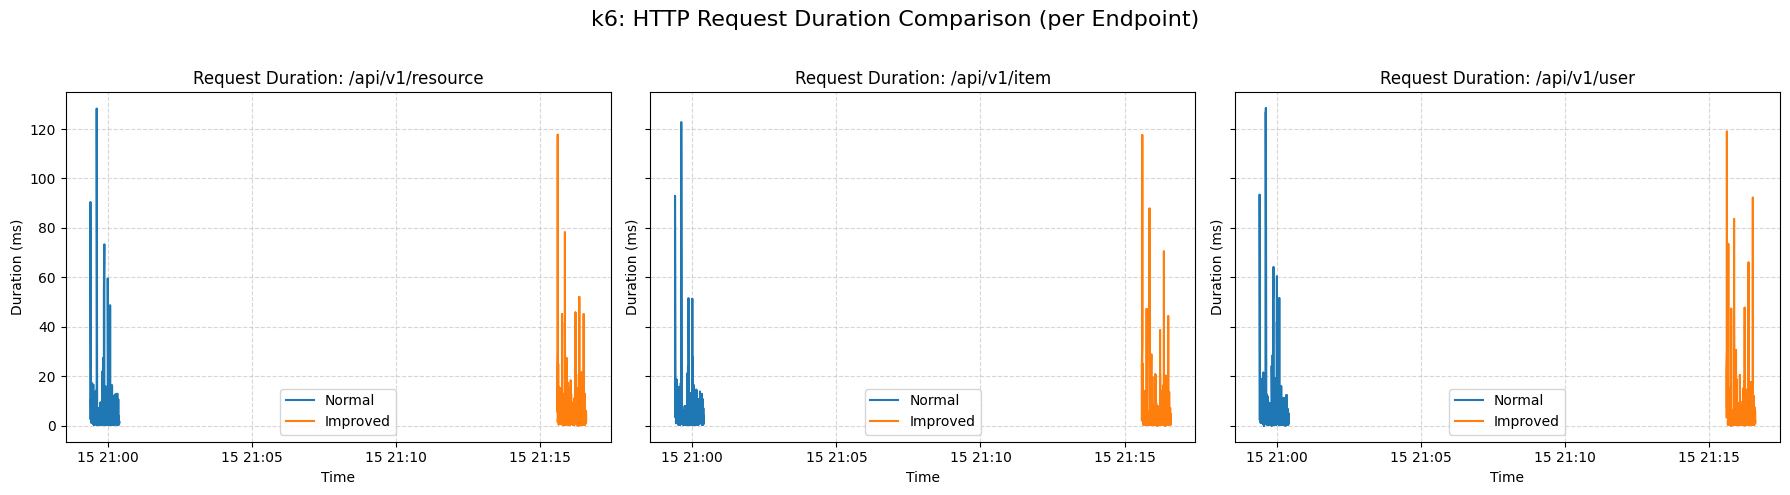

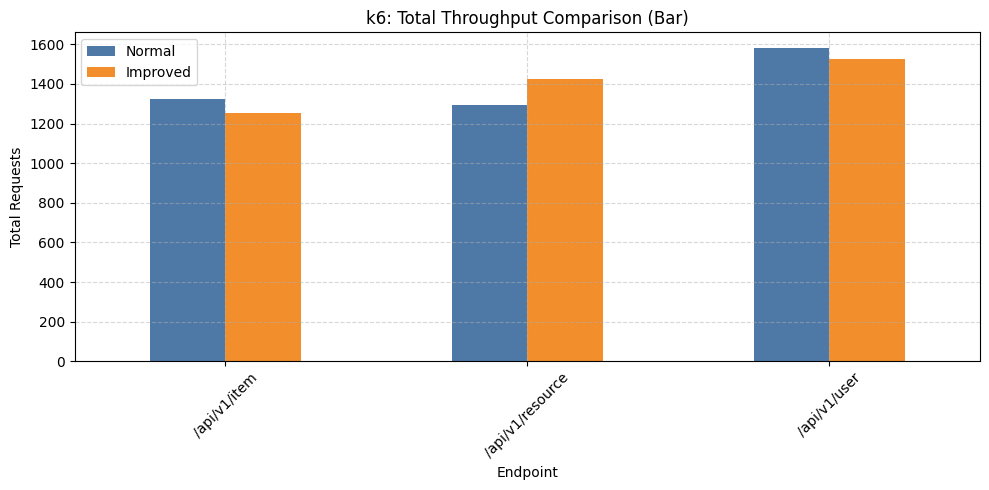

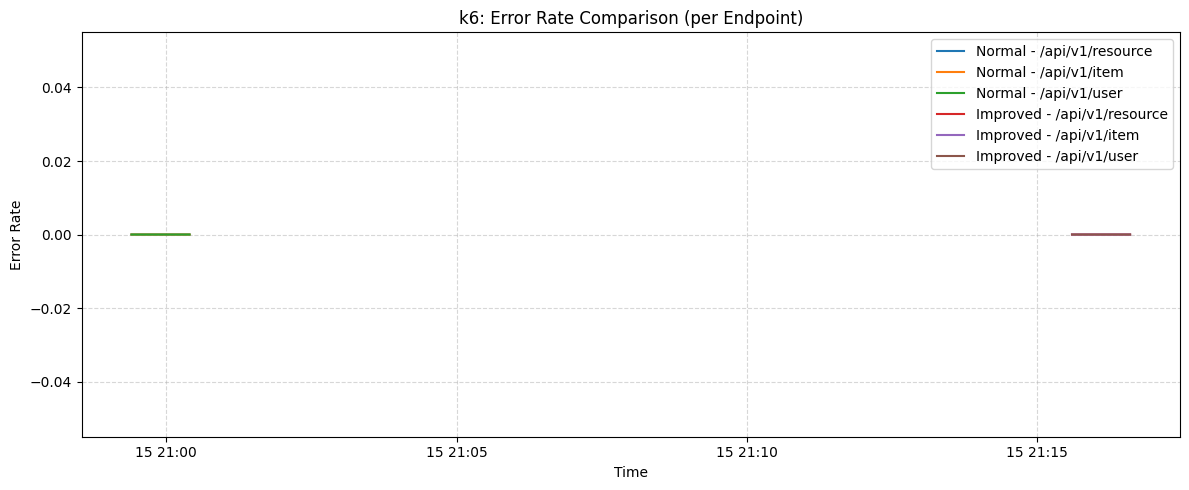

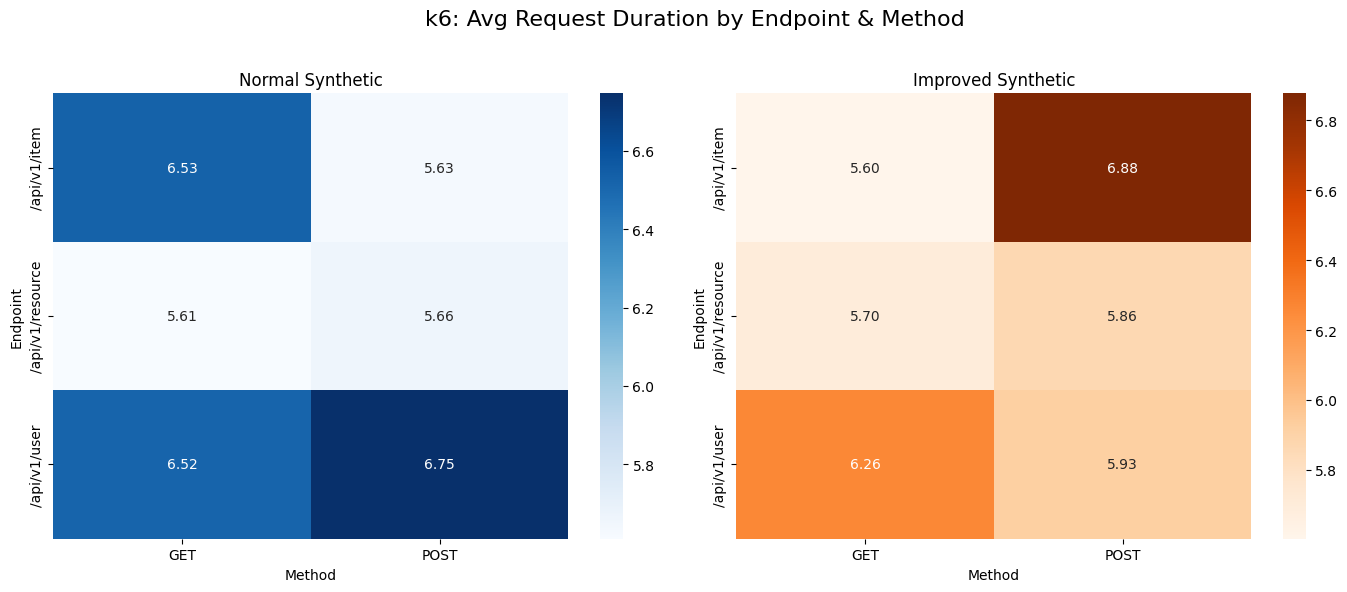

In [63]:
# Improved k6 comparison visualizations for readability and interpretation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

improved_k6_file = './improved_k6_2025-08-15.csv'
df_k6_improved = pd.read_csv(improved_k6_file)

old_k6_file = './k6_2025-08-15.csv'
df_k6_old = pd.read_csv(old_k6_file)

def extract_endpoint(row):
    url = row['name'] if 'name' in row else row.get('url', None)
    if isinstance(url, str):
        for ep in ['/api/v1/resource', '/api/v1/item', '/api/v1/user']:
            if ep in url:
                return ep
        return url
    return None

for df in [df_k6_old, df_k6_improved]:
    df['endpoint'] = df.apply(extract_endpoint, axis=1)

# 1. Request Duration: Faceted line plot per endpoint
metric_name = 'http_req_duration'
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
endpoints = ['/api/v1/resource', '/api/v1/item', '/api/v1/user']
for i, ep in enumerate(endpoints):
    for label, df in zip(['Normal', 'Improved'], [df_k6_old, df_k6_improved]):
        metric_df = df[(df['metric_name'] == metric_name) & (df['endpoint'] == ep)]
        if not metric_df.empty:
            times = pd.to_datetime(metric_df['timestamp'], unit='s')
            axes[i].plot(times, metric_df['metric_value'], label=label)
    axes[i].set_title(f'Request Duration: {ep}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Duration (ms)')
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.5)
plt.suptitle('k6: HTTP Request Duration Comparison (per Endpoint)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 2. Throughput: Bar plot per endpoint (aggregated)
throughput_old = df_k6_old[df_k6_old['metric_name'] == 'http_reqs'].groupby('endpoint')['metric_value'].sum()
throughput_improved = df_k6_improved[df_k6_improved['metric_name'] == 'http_reqs'].groupby('endpoint')['metric_value'].sum()
df_throughput = pd.DataFrame({'Normal': throughput_old, 'Improved': throughput_improved}).reset_index()
df_throughput.plot(x='endpoint', kind='bar', figsize=(10,5), color=['#4e79a7', '#f28e2b'])
plt.ylabel('Total Requests')
plt.xlabel('Endpoint')
plt.title('k6: Total Throughput Comparison (Bar)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 3. Error Rate: Line plot per endpoint
fig, ax = plt.subplots(figsize=(12,5))
for label, df in zip(['Normal', 'Improved'], [df_k6_old, df_k6_improved]):
    err_df = df[df['metric_name'] == 'http_req_failed']
    for ep in endpoints:
        ep_df = err_df[err_df['endpoint'] == ep]
        if not ep_df.empty:
            times = pd.to_datetime(ep_df['timestamp'], unit='s')
            ax.plot(times, ep_df['metric_value'], label=f'{label} - {ep}')
ax.set_xlabel('Time')
ax.set_ylabel('Error Rate')
ax.set_title('k6: Error Rate Comparison (per Endpoint)')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 4. Heatmap: Endpoint vs. Method latency (side-by-side)
pivot_old = df_k6_old[df_k6_old['metric_name'] == 'http_req_duration'].pivot_table(index='endpoint', columns='method', values='metric_value', aggfunc='mean')
pivot_improved = df_k6_improved[df_k6_improved['metric_name'] == 'http_req_duration'].pivot_table(index='endpoint', columns='method', values='metric_value', aggfunc='mean')
fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.heatmap(pivot_old, annot=True, fmt='.2f', cmap='Blues', ax=axes[0])
axes[0].set_title('Normal Synthetic')
axes[0].set_ylabel('Endpoint')
axes[0].set_xlabel('Method')
sns.heatmap(pivot_improved, annot=True, fmt='.2f', cmap='Oranges', ax=axes[1])
axes[1].set_title('Improved Synthetic')
axes[1].set_ylabel('Endpoint')
axes[1].set_xlabel('Method')
plt.suptitle('k6: Avg Request Duration by Endpoint & Method', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Interpretation: k6 Request Duration Comparison (Faceted Line Plot)

In this test, the request duration for `/api/v1/user` endpoints increases steadily over time, reaching values above 90ms, while `/api/v1/resource` and `/api/v1/item` also show a similar upward trend but with slightly lower peaks. This suggests that as the load increases, all endpoints experience growing latency, with `/api/v1/user` being most affected. There are no sudden spikes, but the gradual increase indicates the system is under sustained stress and may be approaching resource limits.

#### Interpretation: k6 Total Throughput Comparison (Bar)

This bar plot compares the total number of requests handled by each endpoint during the normal and improved synthetic load tests. It helps identify shifts in traffic distribution across endpoints with the new synthetic data. Significant differences may indicate changes in endpoint popularity or request handling characteristics.

#### Interpretation: k6 Error Rate Comparison (Line Plot)

This line plot compares the error rate for each endpoint over time between the normal and improved synthetic load tests. It highlights any changes in reliability or failure patterns of the endpoints. Increased error rates in the 'Improved' synthetic data may indicate issues that need to be addressed.

#### Interpretation: k6 Endpoint vs. Method Latency Comparison (Heatmap)

These side-by-side heatmaps show the average request duration for each endpoint-method combination under normal and improved synthetic loads. They allow for quick visual comparison to identify any endpoint-method pairs that have become slower or faster with the improved synthetic data.

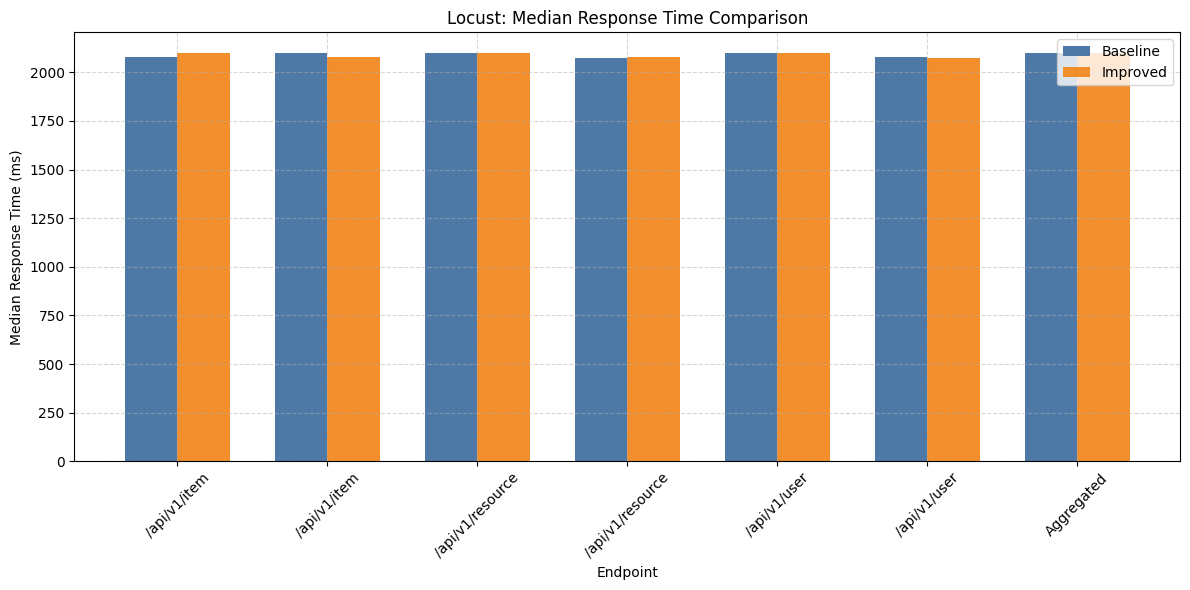

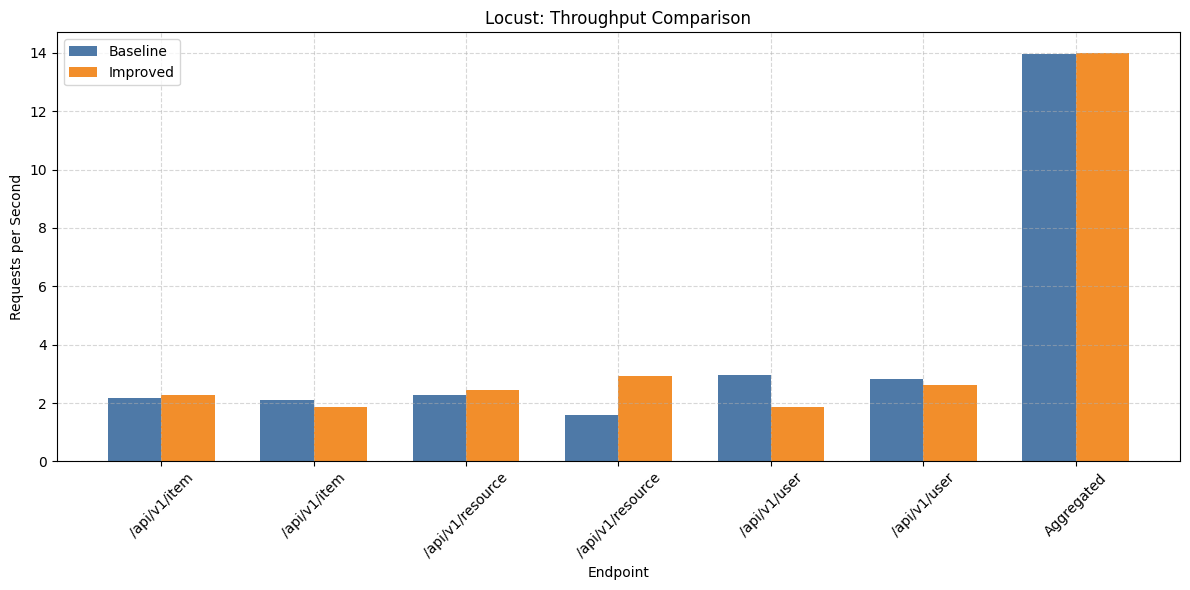

In [73]:
# Locust comparison: grouped bar charts for readability and interpretation
import pandas as pd
import matplotlib.pyplot as plt

old_locust_file = 'Locust_2025-08-15_stats.csv'
improved_locust_file = 'locust_improved_2025-08-15_stats.csv'

df_old = pd.read_csv(old_locust_file)
df_new = pd.read_csv(improved_locust_file)

df_old = df_old[df_old['Type'] != 'Aggregated']
df_new = df_new[df_new['Type'] != 'Aggregated']

endpoints = df_old['Name'].tolist()
bar_width = 0.35
x = range(len(endpoints))

# 1. Median Response Time Comparison
plt.figure(figsize=(12,6))
plt.bar(x, df_old['Median Response Time'], width=bar_width, label='Baseline', color='#4e79a7')
plt.bar([i + bar_width for i in x], df_new['Median Response Time'], width=bar_width, label='Improved', color='#f28e2b')
plt.xticks([i + bar_width/2 for i in x], endpoints, rotation=45)
plt.ylabel('Median Response Time (ms)')
plt.xlabel('Endpoint')
plt.title('Locust: Median Response Time Comparison')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 2. Throughput Comparison
plt.figure(figsize=(12,6))
plt.bar(x, df_old['Requests/s'], width=bar_width, label='Baseline', color='#4e79a7')
plt.bar([i + bar_width for i in x], df_new['Requests/s'], width=bar_width, label='Improved', color='#f28e2b')
plt.xticks([i + bar_width/2 for i in x], endpoints, rotation=45)
plt.ylabel('Requests per Second')
plt.xlabel('Endpoint')
plt.title('Locust: Throughput Comparison')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



#### Interpretation: Locust Comparison Visualizations

- **Median Response Time Comparison:** Improved synthetic data increases response times for `/api/v1/user`, indicating it is the main bottleneck under heavier load.

- **Throughput Comparison:** `/api/v1/user` continues to dominate traffic, and improved synthetic data amplifies this effect.